In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, ttest_ind, f_oneway, stats

In [3]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing(as_frame=True)
df_num = data.frame
df_num.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


**MedInc:** Ingreso medio de los habitantes  
**HouseAge:** Edad media de las casas  
**AveRooms:** Media de habitaciones por casa  
**AveBedrms:** Media de dormitorios por casa  
**Population:** Población total   
**AveOccup:** Media de personas por casa  
**Latitude:** Latitud  
**Longitude:** Longitud   
**MedHouseVal:** Valor medio de las casas

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, ttest_ind, f_oneway, stats

def describe_df(df):
    '''
    Devuelve el df con la descripción de tipo de dato por columna, 
    el tanto por ciento de valores nulos o missings, los valores 
    únicos y el porcentaje de cardinalidad.
    
    Argumentos:
    df (pd.DataFrame): Dataset del que se quiere extraer la descripción.

    Retorna:
    pd.DataFrame: Retorna en el mismo formato el información del argumento df.    
    '''
    df_resultado = pd.DataFrame([df.dtypes, df.isna().sum()*100, df.nunique(), round(df.nunique()/len(df) * 100, 2)]) # Cardinaliad y porcentaje de variación de cardinalidad
    df_resultado = df_resultado.rename(index= {0: "DATA_TYPE", 1: "MISSINGS (%)", 2: "UNIQUE_VALUES", 3: "CARDIN (%)"})
    return df_resultado

In [5]:
describe_df(df_num)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
DATA_TYPE,float64,float64,float64,float64,float64,float64,float64,float64,float64
MISSINGS (%),0,0,0,0,0,0,0,0,0
UNIQUE_VALUES,12928,52,19392,14233,3888,18841,862,844,3842
CARDIN (%),62.64,0.25,93.95,68.96,18.84,91.28,4.18,4.09,18.61


In [6]:
import variables as var

def tipifica_variables(df, umbral_categoria= var.UMBRAL_CATEGORIA, umbral_continua= var.UMBRAL_CONTINUA):
    """
    Asigna un tipo a las variables de un dataframe en base a su cardinalidad y porcentaje de cardinalidad.

    Argumentos: 
        df: el dataframe a analizar
        umbral_categoria (int): número de veces max. que tiene que aparecer una variable para ser categórica
        bral_continua (float): porcentaje mínimo de cardinalidad que tiene que tener una variable para ser numérica continua

    Retorna: 
        Un dataframe con los resultados con dos columnas: 
        - El nombre de la variable 
        - El tipo sugerido para la variable 
        
    """

    resultados = [] #se crea una lista vacía para meter los resultados

    for columna in df.columns: #coge cada columna en el dataframe
        cardinalidad = df[columna].nunique() #calcula la cardinalidad 
        porcentaje_cardinalidad = (cardinalidad / len(df))*100 #calcula el porcentaje 

        if cardinalidad == 2:
            tipo = var.TIPO_BINARIA
            #tipo = "Binaria"

        elif (cardinalidad < umbral_categoria) and (cardinalidad != 2):
            tipo = var.TIPO_CATEGORICA
            #"Categórica"

        elif porcentaje_cardinalidad >= umbral_continua: #mayor que umbral categoria, mayor o igual que umbral continua
            tipo = var.TIPO_NUM_CONTINUA
            #"Numérica Continua"

        else:
            tipo = var.TIPO_NUM_DISCRETA #el porcentaje de cardinalidad es menor que umbral continua 
            #"Numérica Discreta"
        
        resultados.append({"variable": columna, "tipo": tipo}) #mete en la lista de resultados la columna y el tipo que se le asigna 

    return pd.DataFrame(resultados) #crea un dataframe con la lista de resultados 

In [7]:
tipifica_variables(df_num)

,variable,tipo
0,MedInc,Numérica Continua
1,HouseAge,Numérica Discreta
2,AveRooms,Numérica Continua
3,AveBedrms,Numérica Continua
4,Population,Numérica Continua
5,AveOccup,Numérica Continua
6,Latitude,Numérica Discreta
7,Longitude,Numérica Discreta
8,MedHouseVal,Numérica Continua


In [8]:
def get_features_num_regression(df, target_col, umbral_corr, pvalue=None):
    '''
    Selecciona features numéricas basadas en su correlación con la variable target.
    La variable target debe ser numerica con alta cardinalidad.
    
    Args:
        df (pandas.DataFrame): DataFrame de entrada
        target_col (str): Nombre de la columna target
        umbral_corr (float): Umbral de correlación (valor absoluto) entre 0 y 1
        pvalue (float, optional): Nivel de significación para el test de hipótesis
        
    Returns:
        Lista de columnas que cumplen los criterios o None si hay error
    '''
    ## Validaciones de entrada
    # Verifica que target_col exista en el DataFrame y sea una cadena
    if target_col not in df.columns:
        print(f"Error: no encuentro {target_col} en el dataframe.")
        return None
    if not isinstance(target_col, str):
        print(f"Error: {target_col} debe ser una cadena de texto")
        return None
    # Verifica que la columna target_col sea numérica y con alta cardinalidad
    if not np.issubdtype(df[target_col].dtype, np.number):  #np.issubdtype comprueba si el tipo de datos de la columna es un subtipo de np.number (incluyendo enteros y float).
        print(f"Error: La columna '{target_col}' debe ser numérica.")
        return None
    n_unique = df[target_col].nunique()
    if n_unique < var.UMBRAL_CONTINUA:  # umbral arbitrario para considerar alta cardinalidad
        print(f"Error: La columna {target_col} debe tener alta cardinalidad")
        return None
    
    # Verifica que umbral_corr está entre 0 y 1
    if not (0 <= umbral_corr <= 1):
        print("Error: El umbral de correlación debe estar entre 0 y 1.")
        return None
    
    # Validación de pvalue si está presente
    if pvalue is not None and not 0 <= pvalue <= 1:
        print("El valor p debe estar entre 0 y 1.")
        return None
    

    # Lista para almacenar las columnas que cumplen con los criterios
    features_num = []

    # Iterar sobre todas las columnas numéricas del dataframe 
    # excluiendo la target y las numericas con cardinalidad baja que pueden ser consideradas categoricas 
    for col in df.select_dtypes(include=np.number).columns:
        if col != target_col and df[col].nunique() >= var.UMBRAL_CONTINUA:
            corr, p_val = stats.pearsonr(df[target_col].dropna(), df[col].dropna())
            # Verifica que la correlación supera el umbral
            if abs(corr) > umbral_corr:
                # Si pvalue es None, añade la columna
                if pvalue is None:
                    features_num.append(col)
                # Si pvalue no es None, verificar también la significación estadística
                elif p_val <= pvalue:
                    features_num.append(col)
    

    return features_num

In [9]:
get_features_num_regression(df_num, target_col='MedHouseVal', umbral_corr=0.5, pvalue=0.05)


C:\Users\patri\AppData\Local\Temp\ipykernel_15968\626962673.py:50: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  corr, p_val = stats.pearsonr(df[target_col].dropna(), df[col].dropna())


['MedInc']

In [10]:
print(df_num.corr()['MedHouseVal'])


MedInc         0.688075
HouseAge       0.105623
AveRooms       0.151948
AveBedrms     -0.046701
Population    -0.024650
AveOccup      -0.023737
Latitude      -0.144160
Longitude     -0.045967
MedHouseVal    1.000000
Name: MedHouseVal, dtype: float64


In [11]:
import functions as fnc

def plot_features_num_regression(dataframe, target_col="", columns=[], umbral_corr=0, pvalue=None, max_pairplot_column=5):
    """
        Función que analiza la correlación de variables numéricas con la variable target. En el caso de que haya variables correladas
        pintará un pairplot con la comparativa de cada una de ellas.

        Argumentos:
            > dataframe: Dataframe con los datos
            > target_col: Columna target a analizar
            > columns: Columnas con las que buscar la correlación con la columna 'target'. En caso de no especificar
                        nada, se revisrán las variables numéricas que hay en el dataframe
            > umbral_corr: Umbral a partir del cual una columna se va a comparar con el target. Por defecto es 0
            > pvalue: Nivel de significación para el test de hipótesis
            > max_pairplot_column: Número de columnas a pintar. Debe ser mayor o igual a 2. Se define 5 como valor por defecto

        Retorna:
            > Parametro 1: Lista de las columnas que tienen correlación por encima de 'umbral_corr' con la variable target. En el caso de que 
                        haya algún error, se devuelve 'None'
            > Parametro 2: Matriz de correlación con las variables seleccionadas

    """
    final_columns = columns
    # Si no se pasa parámetro 'columns', extraemos todas las columnas numéricas
    if len(final_columns) == 0:
        final_columns = fnc.get_num_colums(dataframe, dataframe.columns)
    
    if not fnc.is_valid_numeric(dataframe, target_col, final_columns):
        return None
    
    # Borramos la columna target de la lista, en el caso de que exista
    if target_col in final_columns:
        final_columns.remove(target_col)

    # Comprobamos si finalmente hay columnas a analizar
    if len(final_columns) == 0:
        print("No se han especificado columnas en el parámetro 'columns' y el set de datos no contiene ninguna columna numérica (diferente al target)")
        return None

    # Verificamos que el número máximo de columnas a pintar es mayor que 2
    if max_pairplot_column < 2:
        print("El valor de la variable 'max_pairplot_column' debe ser mayor o igual a 2")
        return None
    
    corr_columns = fnc.get_corr_columns_num(dataframe, target_col, final_columns, umbral_corr, pvalue)

    # Comprobamos si hay columnas a analizar que correlan con el umbral especificado
    if len(corr_columns) == 0:
        print("No se han encontrado columnas de correlación con los criterios especificados")
        return None
    else:
        #Pintamos el pairplot
        sns.set_style = var.SNS_STYLE
        paint_columns = corr_columns
        while len(paint_columns) > 0:
            sns.pairplot(dataframe[[target_col] + paint_columns[0:max_pairplot_column-1]])
            paint_columns = paint_columns[max_pairplot_column-1:]

    return corr_columns

In [12]:
plot_features_num_regression(df_num, target_col= "MedHouseVal", columns=[], umbral_corr=0.5, pvalue=0.05)

Las siguientes columnas no son del tipo ['Numérica Continua', 'Categórica']: ['HouseAge', 'Latitude', 'Longitude']


In [13]:
columns_to_remove = ['Latitude', 'Longitude', 'HouseAge']
df_num = df_num.drop(columns=columns_to_remove)

['MedInc']

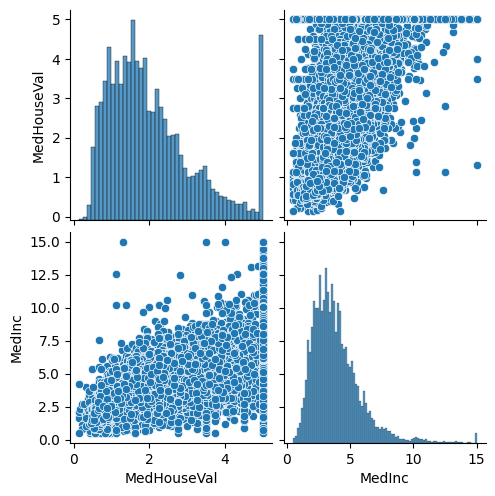

In [14]:
plot_features_num_regression(df_num, target_col= "MedHouseVal", columns=[], umbral_corr=0.5, pvalue=0.05)

In [15]:
df_cat = pd.read_csv(r"C:\Users\patri\REPO_PRUEBA\ONLINE_DS_THEBRIDGE_Patricia_Diez\pruebas_patri\titanic.csv")
df_cat.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [16]:
def get_features_cat_regression(df, target_col, columns=[], pvalue=0.05, with_individual_plot=False):
    significant_columns = []
    
    # Validaciones iniciales
    if target_col not in df.columns:
        print(f"La columna '{target_col}' no está presente en el DataFrame.")
        return None

    if not np.issubdtype(df[target_col].dtype, np.number):
        print(f"La columna '{target_col}' no es numérica continua.")
        return None

    if not columns:  # Si no se especifican columnas, selecciona categóricas por defecto
        columns = df.select_dtypes(exclude=[np.number]).columns.tolist()

    if not columns:
        print("No hay columnas categóricas en el DataFrame.")
        return None

    # Probar cada columna categórica
    for col in columns:
        unique_values = df[col].dropna().unique()
        if len(unique_values) < 2:
            continue  # Omitir columnas sin categorías válidas

        # Selección del test estadístico
        if len(unique_values) == 2:
            group1 = df[df[col] == unique_values[0]][target_col]
            group2 = df[df[col] == unique_values[1]][target_col]
            stat, p = ttest_ind(group1, group2, nan_policy='omit')
        else:
            groups = [df[df[col] == val][target_col] for val in unique_values]
            stat, p = f_oneway(*groups)

        # Verificar si el p-valor es significativo
        if p < pvalue:
            significant_columns.append(col)

            # Visualización opcional
            if with_individual_plot:
                plt.figure(figsize=(10, 6))
                sns.histplot(data=df, x=target_col, hue=col, multiple="stack", kde=True)
                plt.title(f"Histograma de {target_col} agrupado por {col}")
                plt.xlabel(target_col)
                plt.ylabel("Frecuencia")
                plt.show()

    # Retornar columnas significativas
    if not significant_columns:
        print("No se encontraron columnas categóricas significativas.")
        return None

    return significant_columns


In [81]:
get_features_cat_regression(df_cat, target_col="survived")

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


['sex',
 'embarked',
 'class',
 'who',
 'adult_male',
 'embark_town',
 'alive',
 'alone']

In [22]:
import toolbox as tool

def plot_features_cat_regression(dataframe, target_col = "", columns = [], pvalue = 0.05, with_individual_plot = False, size_group = 2): # Cardinalidad numéricas categóricas.

    """
    Pinta los histogramas agrupados de la variable target_col para cada uno de los valores de columns, siempre y cuando el test de significación sea 1-pvalue. 
    Si columns no tiene valores, se pintarán los histogramas de las variables numéricas teniendo en cuenta lo mismo.

    Argumentos:
    dataframe (DataFrame): dataframe a estudiar.
    target_col (str): nombre de la columna con los datos target.
    columns (list): lista con el nombre de las columnas a comparar con target_col.
    pvalue (float64): valor p.
    with_individual_plot (bool): si es True pinta cada histograma por separado.
    size_group (int): por defecto 4. Si las columnas categóricas tienen más categorías que ese argumento, se dividirán sus plots.

    Retorna:
    object: figura o figuras con uno o varios histogramas.
    list: lista con las columnas que se hayan elegido (que tengan significación estadística).
    None: si se produce algún error, se devuelve None y un print con la explicación del error.
    """

    sns.set_style = "whitegrid"
    
    # Comprobamos utilizando la función is_valid_params que las columnas cumplen con su tipo elegido (target numérico y columns categóricas):
    numeric_types = [var.TIPO_NUM_CONTINUA, var.TIPO_NUM_DISCRETA]
    categoric_types = [var.TIPO_BINARIA, var.TIPO_CATEGORICA]
    if not fnc.is_valid_params(dataframe, target_col, columns, numeric_types, categoric_types):
        return None
    
    if len(columns) == 0: # Al no introducir el argumento columns, seleccionamos las variables numéricas:
        df_types = tool.tipifica_variables(dataframe, var.UMBRAL_CATEGORIA, var.UMBRAL_CONTINUA)
        num_col = df_types[df_types[var.COLUMN_TIPO].isin(numeric_types)][var.COLUMN_NOMBRE].to_list()
    
    sig_num_col = []
    sig_cat_col = []

    if columns == []: # Si no introducimos columnas categóricas, cogeremos las columnas numéricas:
        if dataframe[num_col].isna().sum().sum() != 0: # Verificamos si existen nulos para avisar al usuario de que existen:
             print(f"Existen nulos o NaN presentes en las variables numéricas de estudio, tenga en cuenta que el análisis de correlación se realizará eliminando esos nulos.")

        for col in num_col: # Usamos la correlación de pearson para ver si están relacionadas (eliminando nulos en caso de que haya):
            p = pearsonr(dataframe.dropna()[target_col], dataframe.dropna()[col]).pvalue
            if p < pvalue: # Si la relación entre variables entra en la significación seleccionada, nos guardamos esa columna:
                sig_num_col.append(col)
        if target_col in sig_num_col: # Como nuestro target es una variable numérica, la quitamos de la lista
            sig_num_col.remove(target_col)
        if sig_num_col != []:
            print(f"Las columnas numéricas elegidas son: {sig_num_col}")
        else:
             print("No se ha seleccionado ninguna columna numérica.")

    else:
        for col in columns:
            cat = dataframe[col].unique()
            if len(cat) < 2:
                continue
            if len(cat) == 2: # Si la categoría es binaria, utilizamos el test T de Student
                group0 = dataframe.loc[dataframe[col] == cat[0], target_col]
                group1 = dataframe.loc[dataframe[col] == cat[1], target_col]
                p = ttest_ind(group0, group1).pvalue
            else: # Si la columna tiene más de dos categorías, utilizamos ANOVA:
                groups = [dataframe.loc[dataframe[col] == c, target_col] for c in cat]
                p = f_oneway(*groups).pvalue
            if p < pvalue: # Si la relación entre variables entra en la significación seleccionada, nos guardamos esa columna:
                    sig_cat_col.append(col)
        if sig_cat_col != []:
            print(f"Las columnas categóricas elegidas son: {sig_cat_col}")
        else:
             print("No se ha seleccionado ninguna columna categórica.")
    
    if sig_num_col != []:
        if with_individual_plot:
            for col in sig_num_col:
                    # Crea el gráfico
                    plt.figure(figsize=(12, 8))
                    sns.scatterplot(x = target_col, y = col, data = dataframe)
                    plt.title(f"Relación entre {col} y {target_col}")
                    plt.xlabel(col)
                    plt.ylabel(f"{col}")
                    plt.show();

        else:
            subplots = len(sig_num_col) # Guardamos las filas que va a tener nuestra figura
            plt.figure(figsize=(20,15))
            for i, col in enumerate(sig_num_col):
                plt.subplot(subplots, 1, i+1) # Colocamos cada columna en una de las filas de nuestra figura
                sns.scatterplot(x = target_col, y = col, data = dataframe)
                plt.title(f"Relación entre {col} y {target_col}")
                plt.xlabel(col)
                plt.ylabel(f"{col}")
            plt.tight_layout()
            plt.show();
    
    elif sig_cat_col != []:
        if with_individual_plot:
            for col in sig_cat_col:
                unique_categories = dataframe[col].unique()
                if len(unique_categories) > size_group:
                    num_plots = int(np.ceil(len(unique_categories) / size_group))
                    for i in range(num_plots):
                        cat_subset = unique_categories[i * size_group:(i + 1) * size_group]
                        data_subset = dataframe.loc[dataframe[col].isin(cat_subset), [col, target_col]]
                        plt.figure(figsize=(12, 8))
                        sns.histplot(x = target_col, hue = col, data = data_subset, kde = True)
                        plt.xlabel(target_col)
                        plt.ylabel("")
                        plt.show();

                else:
                # Crea el gráfico
                    plt.figure(figsize=(12, 8))
                    sns.histplot(x = target_col, hue = col, data = dataframe, kde = True)
                    plt.title(f"Relación entre {col} y {target_col}")
                    plt.xlabel(target_col)
                    plt.ylabel("")
                    plt.show();

        else:
            subplots = 0
            columns_groups = {}
            for col in sig_cat_col:
                unique_categories = dataframe[col].unique()
                if len(unique_categories) > size_group:
                    num_plots = int(np.ceil(len(unique_categories) / size_group))
                    subplots += num_plots
                    columns_groups[col] = np.array_split(unique_categories, num_plots)
                else:
                    subplots += 1
                    columns_groups[col] = [unique_categories]

            # Crear subgráficas dinámicamente
            fig, axes = plt.subplots(nrows = subplots, ncols = 1, figsize = (20, 5 * subplots))
            if subplots == 1:
                 axes = [axes]  # Asegurarse de que sea iterable si solo hay un subplot
                 # Graficar histogramas
            subplot_idx = 0
            for col, grupos in columns_groups.items():
                for grupo in grupos:
                    # Filtrar datos por el grupo actual
                    data_filtrada = dataframe[dataframe[col].isin(grupo)]

                    # Graficar en el subplot correspondiente
                    sns.histplot(data = data_filtrada, x = target_col, hue = col, ax = axes[subplot_idx])
                    axes[subplot_idx].set_title(f'{col} - Categorías: {list(grupo)}')
                    axes[subplot_idx].set_xlabel(col)
                    axes[subplot_idx].set_ylabel("")
                    subplot_idx += 1

            # Ajustar diseño
            plt.tight_layout()
            plt.show();

In [75]:
plot_features_cat_regression(df_cat, target_col="survived", pvalue=0.05)

La columna 'survived' no es una variable de tipo ['Numérica Continua', 'Numérica Discreta']
